# Open Source Data Science meetup

### Anomaly Detection web app deployment

This notebook will explore car engine data generated via OBDII and will use this dataset to demonstrate an anomaly detection framework**

**The framework for anomaly detection that we will use is defined as follows:**
* First fit a model using Random Forest Regressor or Support Vector Machine Regressor
* Generate the residuals, those can be thought of as a similarity measure
* Train a oneClass Classification on the residuals

<img src="../IMAGES/oneclasscap.PNG" alt="Drawing"/>

Loading up python packages

In [1]:
'''
Jupyter interactive libraries

'''
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from ipywidgets import *
from ipywidgets import widget
import os

'''
Data munging libraries

'''
import pandas as pd
import numpy as np

'''
Visualization Libraries

'''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#%matplotlib notebook
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 2) 
from bokeh.plotting import figure, output_notebook, show, gridplot
from bokeh.layouts import row

'''
ML libraries

'''
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator,TransformerMixin, ClusterMixin ,RegressorMixin
from sklearn.svm import OneClassSVM
output_notebook();

Loading BokehJS ...

In [2]:
# Loading the csv file
filename="engine.csv"
newTable=pd.read_csv(filename,header=0,encoding="ISO-8859-2")

In [3]:
newTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Data columns (total 10 columns):
Time(s)                             7133 non-null float64
dataset                             7133 non-null object
Engine RPM (rpm)                    7133 non-null int64
Ambient Air Temperature (°F)        7133 non-null int64
Vehicle Speed (MPH)                 7133 non-null int64
Absolute Throttle Position (%)      7133 non-null float64
Absolute Load Value (%)             7133 non-null float64
Calculated Engine Load Value (%)    7133 non-null float64
Fuel Level Input (%)                7133 non-null float64
Engine Coolant Temperature (°F)     7133 non-null int64
dtypes: float64(5), int64(4), object(1)
memory usage: 557.3+ KB


In [4]:
engine_df=newTable

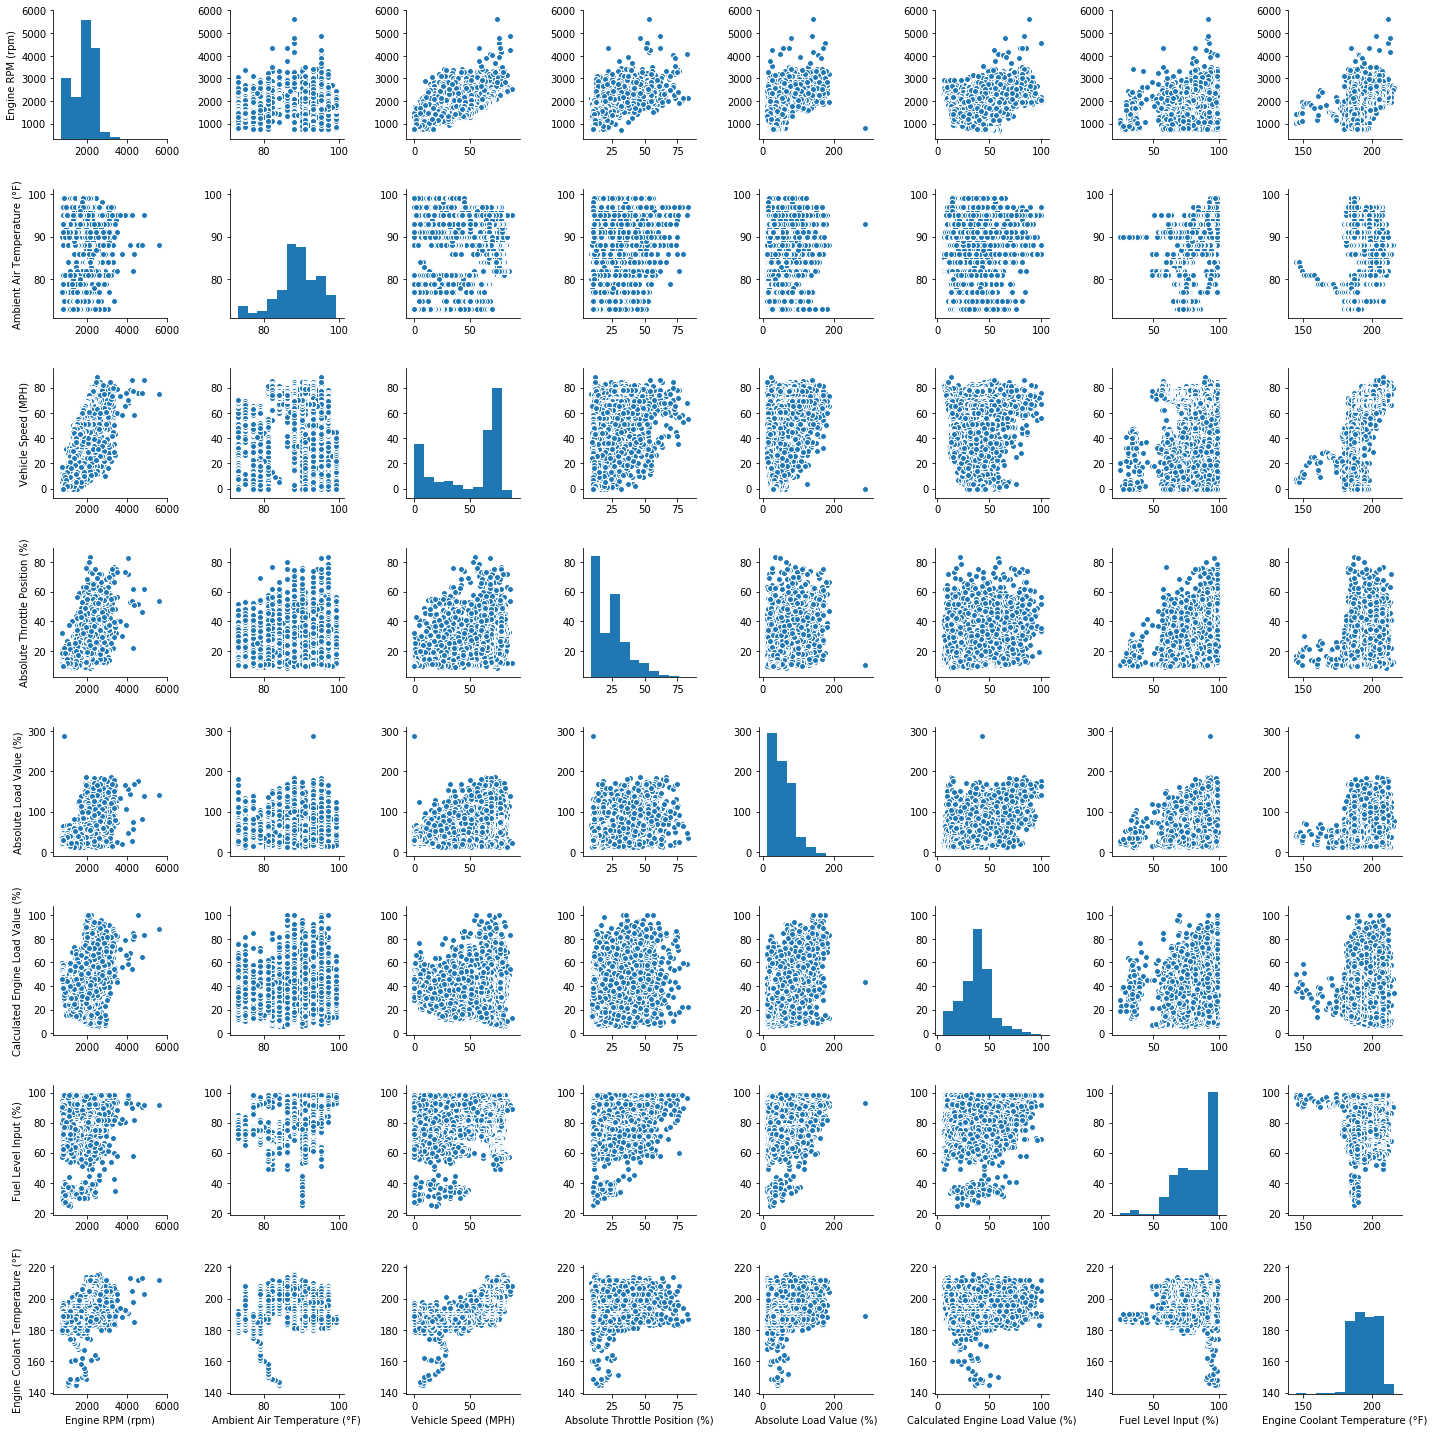

In [5]:
'''
Exploring the data set and looking for correlation in the sensors
'''
sns.pairplot(engine_df.iloc[:,2:])
plt.tight_layout();

We will split the data into training and validation and assume that the validation set is a data set that we streamed later

In [6]:
X=engine_df[['Engine RPM (rpm)','Ambient Air Temperature (°F)', 
                                                           'Vehicle Speed (MPH)','Absolute Throttle Position (%)',
                                                           'Absolute Load Value (%)', 'Calculated Engine Load Value (%)',
                                                           'Fuel Level Input (%)']].values
y=engine_df["Engine Coolant Temperature (°F)"].values
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=2301)

## Scikit-Learn's API is extremely well designed

** All objects have the same consistent and easy to follow interface:**
- Estimators, you execute it through calling fit()
- Transformers, example normalizing the data
- Predictors


** scikit-Learn high level API**
``` python
# First We call the function
lreg=LinearRegression(fit_intercept=True)
#Second we fit the function to X and Y 
lreg.fit(X,y)
#Finally we can start using the fitted algorithm to predict
predval=lreg.predict(X)
```

## Step 1 of our Anomly detection framework: 
### fit a regressor based model to predict Engine coolant temperature

We will be using a random forest regressor. 
To train the model we will follow those steps:
* Create a dictionary of parameters
* Perform a gridsearchcv on the random forest model
* Create a pickle object for the model

In [7]:
modreg= RandomForestRegressor(n_jobs=-1,random_state=2301)
'''
creating parameter list
'''
cv_params = {'n_estimators':[50,100,200],'max_depth': [15,20,100]}

'''
initializing Grid Search method
'''
gs = GridSearchCV(estimator=modreg,param_grid=cv_params,
                  scoring="neg_mean_squared_error",cv=5,return_train_score=False);

In [8]:
gs.fit(X_train, y_train);

``` python
gs.best_estimator_  
```
Will give us the gridsearch result for best model 

In [9]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=2301, verbose=0, warm_start=False)

** Let's plot our results**

Notice we can run predict straight off gridsearch as it will use the best estimator as the model

In [10]:
y_train_pred=gs.predict(X_train)
y_val_pred=gs.predict(X_val)
'''
creating a new plot with a title and axis labels. 
'''
p1 = figure(plot_width=350, plot_height=350,title="training actual vs predicted", x_axis_label='actual', 
            y_axis_label='predicted')
p2 = figure(plot_width=350, plot_height=350,title="Validation actual vs predicted", x_axis_label='actual', 
            y_axis_label='predicted')
p1.scatter(y_train, y_train_pred),p2.scatter(y_val, y_val_pred);

In [11]:
show(row(p1,p2));

We Can see from the plots that our model is overfitting the training data and is not generalizing as well on the validation set. We won't be optimzing the model as part of this illustration, but generally for production level work such high variance on the validation set is undesirable

### Before we deploy model we need to refit onto our entire data set

In [12]:
best_estim=gs.best_estimator_ # notice we didn't apply fit to Gridsearch again, as this will change the hyperparameters
best_estim=best_estim.fit(X,y)

In [13]:
y_pred=best_estim.predict(X)
'''
creating a new plot with a title and axis labels. 
'''
p1 = figure(plot_width=500, plot_height=500,title="training actual vs predicted", x_axis_label='actual', 
            y_axis_label='predicted')

p1.scatter(y, y_pred);

In [14]:
show(p1);

In [15]:
dest = os.path.join('pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

We now want to serialize our regressor model so we can use it in our anomaly detection framework.

In [16]:
joblib.dump(best_estim,os.path.join(dest,'ranf.pkl'));

** To pass results from the regressor to the oneClass SVM we will create a Scikit Learn pipeline**

## What are scikit learn Pipelines:

a Sequence of tansformers and estimators chained squentially together. for example: normalizing the data followed by fitting into a linear regression


## For Making custom Transformers and adding them to pipelines
- The transformer should work seamlessly with Scikit-Learn pipelines

- Scikit-Learn uses duck typing (not inheritance), so all you need to do is follow the API

- No need to inherit from scikit-learn classes

- Create a class and implement three methods: fit() (returning self), transform(), and fit_transform(). 

# Generate the residuals, those can be thought of as a similarity measure

``` python
class CreateResiduals(BaseEstimator, TransformerMixin):
    def __init__(self,param=True): # no *args or **kargs
        self.param = param
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        exog,endog=X[:,:-1],X[:,-1].reshape(-1,1)
        endog_pred=(joblib.load('pkl_objects/ranf.pkl').predict(exog)).reshape(-1,1)
        resid=endog - endog_pred
        return np.c_[resid]
```

**Creating our full pipeline:**
* The new CreateResiduals class described above is stored in the pyton file custom.py

In [17]:
import custom

# Our last step of our framework:
## Train a oneClass classifier on the residuals

In [18]:
regres_ppl=Pipeline([('resid',custom.CreateResiduals()),
                    ("isof",IsolationForest(contamination=0.,random_state=2301))])

In [19]:
datafit=np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)

In [20]:
regres_ppl.fit(datafit);

# Our job is done
** We now want to serialize this pipeline so we can call it from the webapp**

In [21]:
joblib.dump(regres_ppl,os.path.join(dest,'reg_ppl.pkl'));

In [22]:
trainoutl_df=pd.DataFrame(datafit,columns=['Engine RPM (rpm)','Ambient Air Temperature (°F)', 
                                                           'Vehicle Speed (MPH)','Absolute Throttle Position (%)',
                                                           'Absolute Load Value (%)', 'Calculated Engine Load Value (%)',
                                                           'Fuel Level Input (%)',"Engine Coolant Temperature (°F)"])
trainoutl_df["predicted"]=joblib.load('pkl_objects/ranf.pkl').predict(X_train)
trainoutl_df["residuals"]=trainoutl_df["predicted"]-trainoutl_df["Engine Coolant Temperature (°F)"]
trainoutl_df["outlier_status"]=joblib.load('pkl_objects/reg_ppl.pkl').predict(datafit)

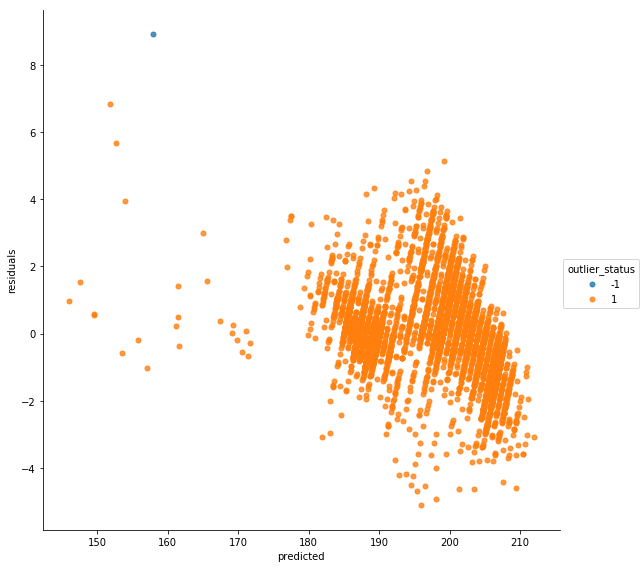

In [23]:
sns.lmplot(x="predicted", y="residuals", data=trainoutl_df, size=8,hue="outlier_status",
           fit_reg=False,scatter_kws={"s": 25});

In [24]:
valset=np.concatenate((X_val,y_val.reshape(-1,1)),axis=1)
valoutl_df=pd.DataFrame(valset,columns=['Engine RPM (rpm)','Ambient Air Temperature (°F)', 
                                                           'Vehicle Speed (MPH)','Absolute Throttle Position (%)',
                                                           'Absolute Load Value (%)', 'Calculated Engine Load Value (%)',
                                                           'Fuel Level Input (%)',"Engine Coolant Temperature (°F)"])
valoutl_df["predicted"]=joblib.load('pkl_objects/ranf.pkl').predict(X_val)
valoutl_df["residuals"]=valoutl_df["predicted"]-valoutl_df["Engine Coolant Temperature (°F)"]
valoutl_df["outlier_status"]=joblib.load('pkl_objects/reg_ppl.pkl').predict(valset)

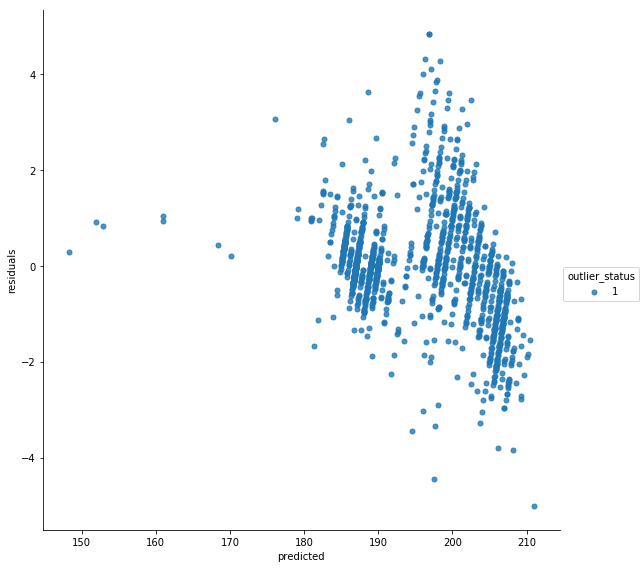

In [25]:
sns.lmplot(x="predicted", y="residuals", data=valoutl_df, size=8,hue="outlier_status",
           fit_reg=False,scatter_kws={"s": 25});

** Plot above showing no issues with engine coolant temperature on the validation set, outlier_status=1 means only normal data**

In [26]:
test_df=pd.read_csv("test_data.csv",header=0,encoding="ISO-8859-2")

In [27]:
X_test=test_df[['Engine RPM (rpm)','Ambient Air Temperature (°F)', 
                                                           'Vehicle Speed (MPH)','Absolute Throttle Position (%)',
                                                           'Absolute Load Value (%)', 'Calculated Engine Load Value (%)',
                                                           'Fuel Level Input (%)']]
y_test=test_df["Engine Coolant Temperature (°F)"]
test_df["predicted"]=joblib.load('pkl_objects/ranf.pkl').predict(X_test.values)
test_df["residuals"]=test_df["predicted"]-test_df["Engine Coolant Temperature (°F)"]
test_df["outlier_status"]=joblib.load('pkl_objects/reg_ppl.pkl').predict(
    test_df[['Engine RPM (rpm)','Ambient Air Temperature (°F)', 
                                                           'Vehicle Speed (MPH)','Absolute Throttle Position (%)',
                                                           'Absolute Load Value (%)', 'Calculated Engine Load Value (%)',
                                                           'Fuel Level Input (%)','Engine Coolant Temperature (°F)']].values)

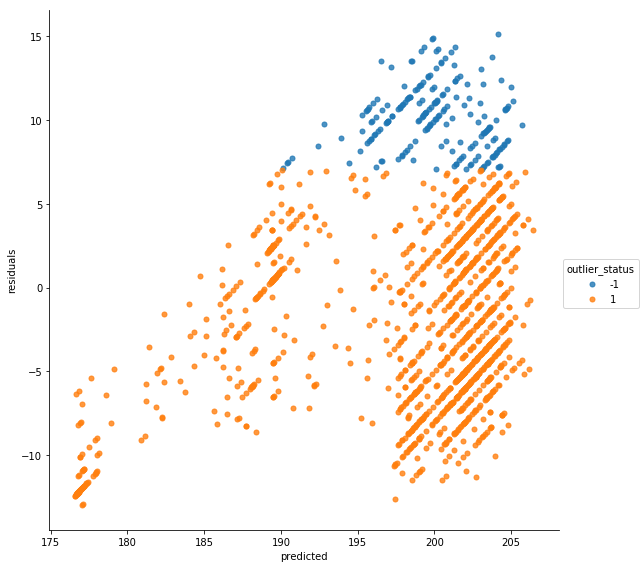

In [28]:
sns.lmplot(x="predicted", y="residuals", data=test_df, size=8,hue="outlier_status",
           fit_reg=False,scatter_kws={"s": 25});

** Plot above showing some issues with engine coolant temperature on the test set, outlier_status=1 means normal data**